In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score, average_precision_score
import torch
import re
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import random

In [ ]:
# ============================================================
# LOAD DATA
# ============================================================
df_path = "/content/drive/MyDrive/Skripsi/Coffee.csv"

df = pd.read_csv(df_path, nrows=38000)
print("Rows loaded:", len(df))
df.head()

Rows loaded: 38000


,business_id,cafe_name,cafe_categories,city,state,text,stars,cafe_rating
0,7T1VAYHIS3cgsDj3iS6JWQ,The Frosted Fox Cake Shop,"Bakeries, Food",Philadelphia,PA,Cute lil spot on Germantown Ave. I came in cra...,4,5.0
1,GOSVLhjUT6TnrPhkkmDOpw,Vineyards Cafe,"Coffee & Tea, Cafes, Food, Creperies, Internet...",Philadelphia,PA,I honestly didn't know this place existed unti...,5,4.5
2,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,"Cafes, Pakistani, Juice Bars & Smoothies, Rest...",Philadelphia,PA,I am not an indian food type of person but thi...,5,4.5
3,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,"Cafes, Pakistani, Juice Bars & Smoothies, Rest...",Philadelphia,PA,Amazing place for lassi and chaat. The chaat i...,5,4.5
4,vCHNWdW-ys-nWUx3Cpvk8Q,Swiss Haus Cafe & Pastry Bar,"Bakeries, Kosher, Food, Restaurants, Coffee & Tea",Philadelphia,PA,Outrageous birthday cake! We chose the Devils ...,5,4.0


In [ ]:
# ============================================================
# DATA CLEANING
# ============================================================
def clean_text(text):
    text = str(text)
    text = re.sub(r"<.*?>", " ", text)                   # remove html
    text = re.sub(r"http\S+|www\S+", " ", text)          # remove urls
    text = re.sub(r"\s+", " ", text).strip()             # normalize whitespace
    return text

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'].str.strip().astype(bool)].reset_index(drop=True)
df.head()

,business_id,cafe_name,cafe_categories,city,state,text,stars,cafe_rating,clean_text
0,7T1VAYHIS3cgsDj3iS6JWQ,The Frosted Fox Cake Shop,"Bakeries, Food",Philadelphia,PA,Cute lil spot on Germantown Ave. I came in cra...,4,5.0,Cute lil spot on Germantown Ave. I came in cra...
1,GOSVLhjUT6TnrPhkkmDOpw,Vineyards Cafe,"Coffee & Tea, Cafes, Food, Creperies, Internet...",Philadelphia,PA,I honestly didn't know this place existed unti...,5,4.5,I honestly didn't know this place existed unti...
2,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,"Cafes, Pakistani, Juice Bars & Smoothies, Rest...",Philadelphia,PA,I am not an indian food type of person but thi...,5,4.5,I am not an indian food type of person but thi...
3,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,"Cafes, Pakistani, Juice Bars & Smoothies, Rest...",Philadelphia,PA,Amazing place for lassi and chaat. The chaat i...,5,4.5,Amazing place for lassi and chaat. The chaat i...
4,vCHNWdW-ys-nWUx3Cpvk8Q,Swiss Haus Cafe & Pastry Bar,"Bakeries, Kosher, Food, Restaurants, Coffee & Tea",Philadelphia,PA,Outrageous birthday cake! We chose the Devils ...,5,4.0,Outrageous birthday cake! We chose the Devils ...


In [ ]:
# ============================================================
# EDA
# ============================================================
display(df.info())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   business_id      38000 non-null  object 
 1   cafe_name        38000 non-null  object 
 2   cafe_categories  38000 non-null  object 
 3   city             38000 non-null  object 
 4   state            38000 non-null  object 
 5   text             38000 non-null  object 
 6   stars            38000 non-null  int64  
 7   cafe_rating      38000 non-null  float64
 8   clean_text       38000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.6+ MB


None

,0
business_id,0
cafe_name,0
cafe_categories,0
city,0
state,0
text,0
stars,0
cafe_rating,0
clean_text,0


/tmp/ipython-input-1339761123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df, palette='pastel')


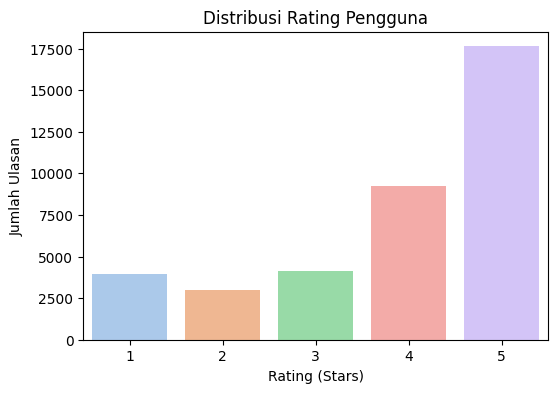

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='stars', data=df, palette='pastel')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating (Stars)')
plt.ylabel('Jumlah Ulasan')
plt.show()

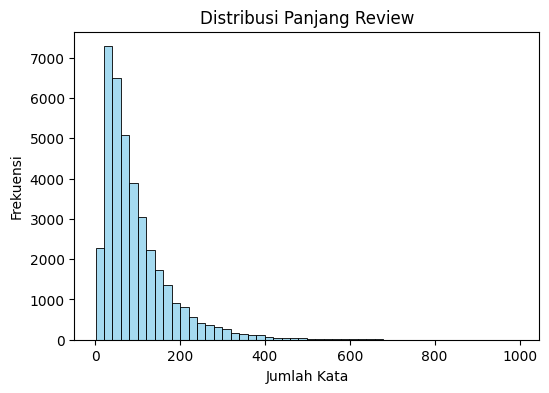

In [ ]:
plt.figure(figsize=(6,4))
df['review_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50, color='skyblue')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

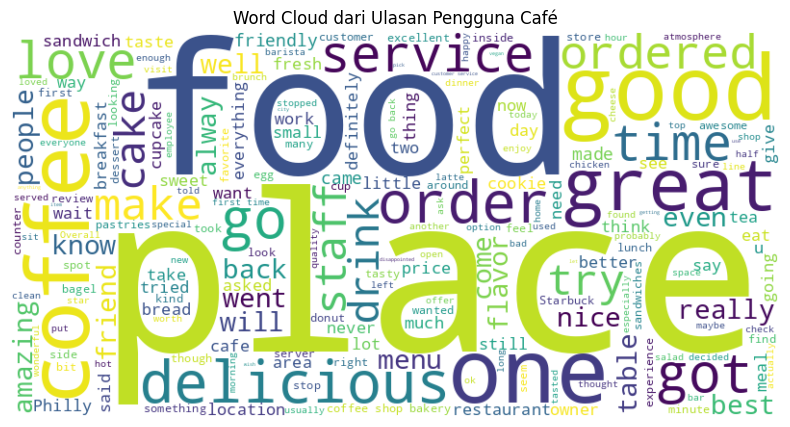

In [ ]:
all_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Ulasan Pengguna Café")
plt.show()

/tmp/ipython-input-2499740348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='review_length', data=df, palette='Set3')


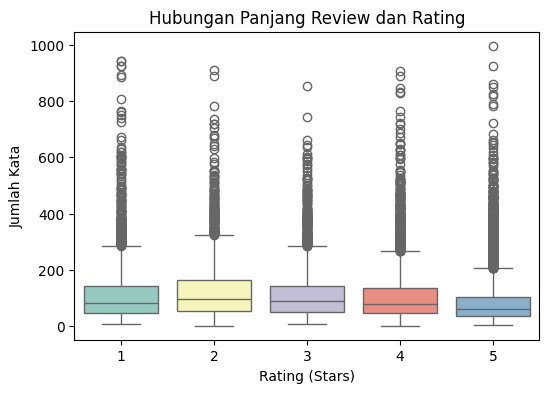

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='stars', y='review_length', data=df, palette='Set3')
plt.title('Hubungan Panjang Review dan Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Jumlah Kata')
plt.show()

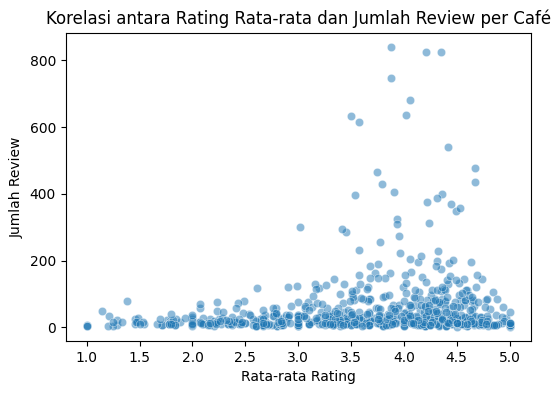

In [ ]:
cafe_stats = df.groupby('business_id')['stars'].agg(['mean','count']).reset_index()

plt.figure(figsize=(6,4))
sns.scatterplot(x='mean', y='count', data=cafe_stats, alpha=0.5)
plt.title('Korelasi antara Rating Rata-rata dan Jumlah Review per Café')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Jumlah Review')
plt.show()

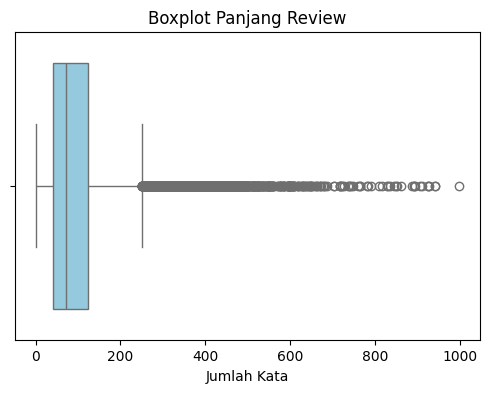

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['review_length'], color='skyblue')
plt.title('Boxplot Panjang Review')
plt.xlabel('Jumlah Kata')
plt.show()

In [ ]:
df['word_len'] = df['clean_text'].apply(lambda x: len(x.split()))

print(df['word_len'].describe())
print("95th:", np.percentile(df['word_len'], 95))
print("99th:", np.percentile(df['word_len'], 99))
print("MAX:", df['word_len'].max())

count    38000.000000
mean        96.335316
std         84.393545
min          1.000000
25%         40.000000
50%         71.000000
75%        124.000000
max        997.000000
Name: word_len, dtype: float64
95th: 258.0
99th: 413.01000000000204
MAX: 997


In [ ]:
# ============================================================
# HANDLING MISSING VALUE
# ============================================================
df = df.dropna(subset=['clean_text', 'stars']).reset_index(drop=True)

# ============================================================
# HANDLING OUTLIER
# ============================================================
q1, q3 = df['review_length'].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Jika ingin menghapus ekstrem (opsional): currently kept as in original
df = df[(df['review_length'] >= lower) & (df['review_length'] <= upper)].reset_index(drop=True)
print(f"Jumlah data setelah hapus outlier: {len(df)}")

Jumlah data setelah hapus outlier: 34765


In [ ]:
# ============================================================
# LABEL ENCODING SENTIMEN
# ============================================================
def label_sentiment(stars):
    # perbaiki indentasi & aman untuk string
    try:
        s = float(stars)
    except:
        return "neutral"
    if s >= 4:
        return "positive"
    elif s == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment'] = df['stars'].apply(label_sentiment)
print("\nDistribusi sentimen:")
print(df['sentiment'].value_counts())



Distribusi sentimen:
sentiment
positive    25044
negative     6042
neutral      3679
Name: count, dtype: int64


In [ ]:
# ============================================================
# STRATIFIED SAMPLING
# ============================================================
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['sentiment'],
    random_state=42
)

print(len(train_df), len(test_df))


27812 6953


In [ ]:
# ============================================================
# MODELING BERT
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define missing constants
MAX_LEN = 320
BATCH_SIZE = 32
LR = 2e-5
EPOCHS = 3
PATIENCE = 2 # for early stopping
OUTPUT_DIR = "./models" # Directory to save the best model

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

le = LabelEncoder()
train_labels = le.fit_transform(train_df['sentiment'])
test_labels = le.transform(test_df['sentiment'])

train_ds = ReviewDataset(train_df['clean_text'].values, train_labels, tokenizer)
test_ds  = ReviewDataset(test_df['clean_text'].values, test_labels, tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_loss = np.inf
patience = 0

# Create the output directory if it doesn't exist
import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        output = model(input_ids=input_ids, attention_mask=attn, labels=labels)
        loss = output.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        train_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg = train_loss / len(train_loader)
    print("Train Loss:", avg)

    # VALIDATION
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            loss = model(input_ids=input_ids, attention_mask=attn, labels=labels).loss
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print("Val Loss:", val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), f"{OUTPUT_DIR}/best_model.pt")
    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping!")
            break


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|█████████████████████████████████████| 870/870 [24:21<00:00,  1.68s/it, loss=0.0416]


Train Loss: 0.4202119999961264
Val Loss: 0.30701414750325023


Epoch 2/3: 100%|█████████████████████████████████████| 870/870 [24:16<00:00,  1.67s/it, loss=0.2225]


Train Loss: 0.23173283135154465
Val Loss: 0.27877769974667


Epoch 3/3: 100%|█████████████████████████████████████| 870/870 [24:16<00:00,  1.67s/it, loss=1.6209]


Train Loss: 0.16020341073430475
Val Loss: 0.30582353445368077


100%|██████████| 218/218 [01:59<00:00,  1.82it/s]


Accuracy: 0.8929958291385014
Precision: 0.8875975223744057
Recall: 0.8929958291385014
F1 score: 0.8895758829262335


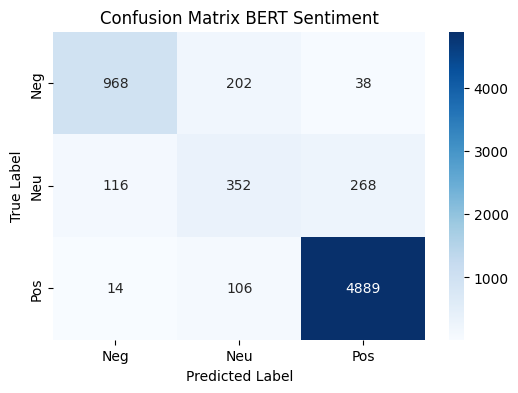

In [ ]:
# ============================================================
# EVALUASI MODEL
# ============================================================

from sklearn.metrics import confusion_matrix

# Load model terbaik
model.load_state_dict(torch.load(f"{OUTPUT_DIR}/best_model.pt"))
model.to(model.device)

preds = []
true = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(model.device)
        attn = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        logits = model(input_ids=input_ids, attention_mask=attn).logits
        pred = torch.argmax(logits, dim=1).cpu().numpy()

        preds.extend(pred)
        true.extend(labels.cpu().numpy())

acc = accuracy_score(true, preds)
prec, rec, f1, _ = precision_recall_fscore_support(true, preds, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)

cm = confusion_matrix(true, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix BERT Sentiment")
plt.show()

In [ ]:
# ============================================================
# COMPUTE CLS EMBEDDINGS
# ============================================================
def embed(texts):
    model.eval()

    fake_labels = [0] * len(texts)
    ds = ReviewDataset(texts, fake_labels, tokenizer, max_len=320)

    loader = DataLoader(ds, batch_size=32, shuffle=False)

    emb = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Embedding"):
            ids = batch["input_ids"].to(model.device)
            attn = batch["attention_mask"].to(model.device)

            out = model.bert(ids, attention_mask=attn).last_hidden_state[:, 0, :]
            emb.append(out.cpu().numpy())

    return np.vstack(emb)

review_embeddings = embed(df['clean_text'].tolist())
review_embeddings.shape

Embedding: 100%|██████████| 1087/1087 [09:59<00:00,  1.81it/s]


(34765, 768)

In [ ]:
# ============================================================
# PROFIL CAFÉ & DISTRIBUSI SENTIMEN (REVISI)
# ============================================================

df['emb_idx'] = df.index

mean_embs = {}
sent_score = {}

for biz, grp in df.groupby('business_id'):
    idxs = grp['emb_idx'].values
    mean_embs[biz] = review_embeddings[idxs].mean(axis=0)


    pos = (grp['sentiment'] == 'positive').mean()
    neu = (grp['sentiment'] == 'neutral').mean()
    neg = (grp['sentiment'] == 'negative').mean()

    # 3. Sentiment score berbasis 3 kelas
    # index ∈ [-1, 1]
    sent_score[biz] = pos - neg

# list café
cafe_ids = list(mean_embs.keys())
cafe_emb_matrix = np.vstack([mean_embs[b] for b in cafe_ids])
sent_score_vec = np.array([sent_score[b] for b in cafe_ids])

In [ ]:
# ============================================================
# SISTEM REKOMENDASI COSINE SIMILARITY & FILTERING LOKASI
# ============================================================

def recommend_cafe(user_text, city=None, state=None, top_n=5):
    txt = clean_text(user_text)

    # --- 1) FILTER LOKASI ---
    df_filtered = df.copy()
    if city:
        df_filtered = df_filtered[df_filtered['city'].str.lower() == city.lower()]
    if state:
        df_filtered = df_filtered[df_filtered['state'].str.lower() == state.lower()]

    if len(df_filtered) == 0:
        return pd.DataFrame({"msg": ["No café found in selected location."]})

    filtered_ids = df_filtered['business_id'].unique().tolist()
    mask = [i for i, cid in enumerate(cafe_ids) if cid in filtered_ids]

    emb_filtered = cafe_emb_matrix[mask]
    sent_filtered = sent_score_vec[mask]
    id_filtered = [cafe_ids[i] for i in mask]

    # --- 2) Embed Input User ---
    enc = tokenizer.encode_plus(
        txt,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(model.device)
    attention_mask = enc["attention_mask"].to(model.device)

    with torch.no_grad():
        cls = model.bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :].cpu().numpy()

    # --- 3) Semantic Similarity ---
    sim_sem = cosine_similarity(cls, emb_filtered)[0]

    # --- 4) Hybrid Scoring (REVISI) ---
    sent_norm = (sent_filtered + 1) / 2
    hybrid_score = 0.7 * sim_sem + 0.3 * sent_norm

    # --- 5) Ranking ---
    idxs = hybrid_score.argsort()[::-1][:top_n]

    rows = []
    for i in idxs:
        bid = id_filtered[i]
        row = df[df['business_id'] == bid].iloc[0]
        rows.append({
            "business_id": bid,
            "cafe_name": row["cafe_name"],
            "categories": row["cafe_categories"],
            "city": row["city"],
            "state": row["state"],
            "cafe_rating": row["cafe_rating"],
            "semantic_similarity": float(sim_sem[i]),
            "sentiment_score": float(sent_filtered[i]),
            "hybrid_score": float(hybrid_score[i])
        })

    return pd.DataFrame(rows)

# TEST
recommend_cafe("i want a cozy quiet cafe for studying", city="Newtown")

,business_id,cafe_name,categories,city,state,cafe_rating,semantic_similarity,sentiment_score,hybrid_score
0,E5QDrZPan50Rd7jWcaFyfg,Starbucks,"Coffee & Tea, Food",Newtown,PA,4.0,0.751530,0.600000,0.766071
1,KnWJ1iJWZ_tbQNlXDFtVwA,Starbucks,"Coffee & Tea, Food, Restaurants",Newtown,PA,3.5,0.775611,0.369565,0.748362
2,d-FXBUOsu1KXFypLt5bGqg,The Coffee Room,"Coffee & Tea, Food",Newtown,PA,4.0,0.670277,0.628205,0.713425
3,caMiHTdikzeZqIb5j2B6Hw,Bagel Junction Deli,"Bakeries, Delis, Food, Restaurants, Bagels",Newtown,PA,3.5,0.699524,0.454545,0.707849
4,c4vpX-TSLeAvfjyVIthokg,Barbie's Soft Pretzels,"Bakeries, Specialty Food, Fruits & Veggies, Food",Newtown,PA,5.0,0.436418,1.000000,0.605493


Average Similarity@5: 0.9804
nDCG@5 (proxy relevance): 0.9782


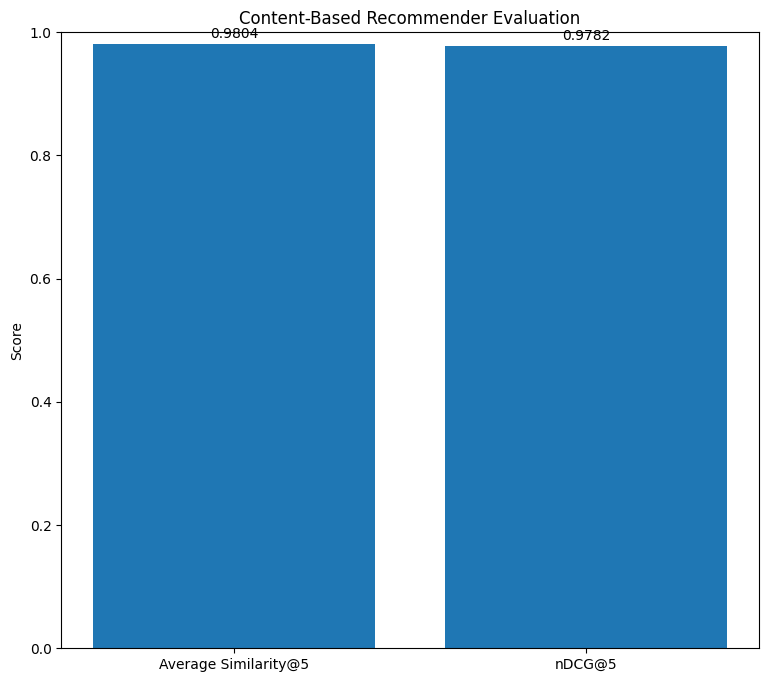

In [ ]:
# ============================================================
# EVALUASI CONTENT-BASED RECOMMENDER
# Intrinsic (Average Similarity) + Proxy-based (nDCG)
# ============================================================

# Proxy relevance berbasis sentiment → [0,1]
sent_relevance = (sent_score_vec + 1) / 2


def eval_avg_sim_ndcg(k=5):
    avg_sim_scores = []
    ndcg_scores = []

    for i in range(len(cafe_ids)):
        # 1. Query café (item-to-item)
        q = cafe_emb_matrix[i:i+1]

        # 2. Similarity query ke semua café
        scores = cosine_similarity(q, cafe_emb_matrix)[0]

        # 3. Ambil Top-K (exclude self)
        order = scores.argsort()[::-1]
        order = order[order != i][:k]

        avg_sim_scores.append(np.mean(scores[order]))

        rel_k = sent_relevance[order]
        ndcg_scores.append(
            ndcg_score([rel_k], [scores[order]])
        )

    return np.mean(avg_sim_scores), np.mean(ndcg_scores)


avg_sim, ndcg = eval_avg_sim_ndcg(k=5)
print("Average Similarity@5:", round(avg_sim, 4))
print("nDCG@5 (proxy relevance):", round(ndcg, 4))

# Hasil evaluasi
metrics = ['Average Similarity@5', 'nDCG@5']
values = [avg_sim, ndcg]

plt.figure(figsize=(9, 8))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Content-Based Recommender Evaluation')

# Tampilkan nilai di atas bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.show()


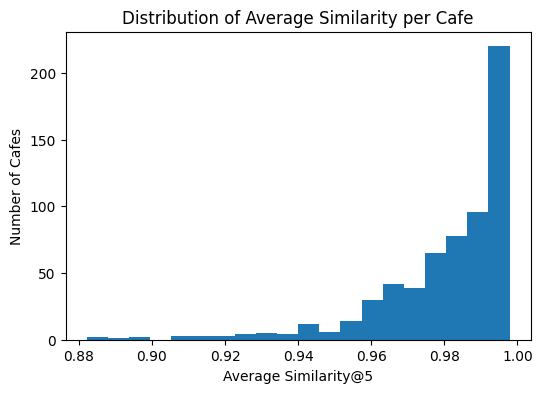

In [ ]:
# ====================================================
# Distribusi Avg Similarity per Item
# ====================================================

def eval_avg_sim_distribution(k=5):
    avg_sim_scores = []

    for i in range(len(cafe_ids)):
        q = cafe_emb_matrix[i:i+1]
        scores = cosine_similarity(q, cafe_emb_matrix)[0]
        order = scores.argsort()[::-1]
        order = order[order != i][:k]
        avg_sim_scores.append(np.mean(scores[order]))

    return avg_sim_scores


avg_sim_dist = eval_avg_sim_distribution(k=5)

plt.figure(figsize=(6, 4))
plt.hist(avg_sim_dist, bins=20)
plt.xlabel('Average Similarity@5')
plt.ylabel('Number of Cafes')
plt.title('Distribution of Average Similarity per Cafe')
plt.show()

Average Similarity@5 (Hold-out): 0.9798
nDCG@5 (Hold-out): 0.975


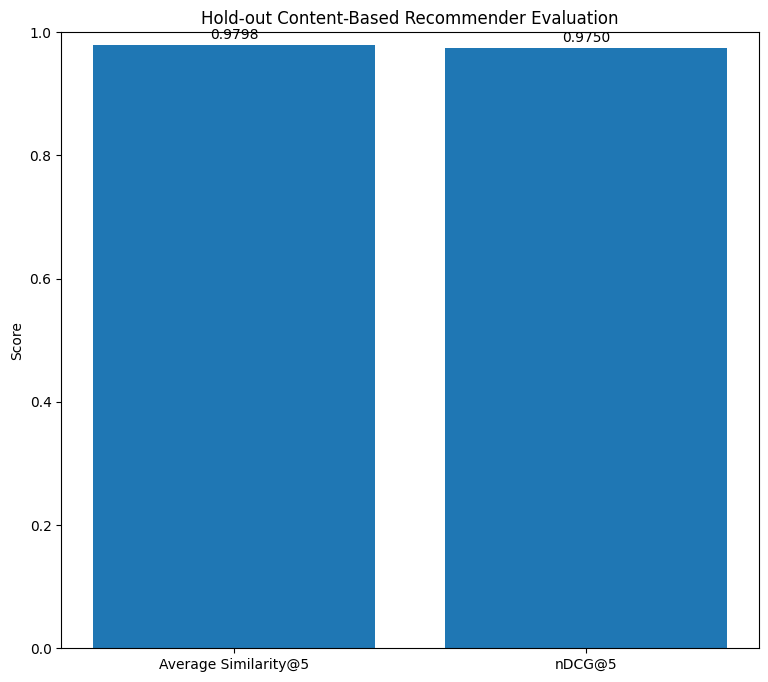

In [ ]:
# ====================================================
# Hold Out Evaluasi
# ====================================================

sent_relevance = (sent_score_vec + 1) / 2

train_idx, holdout_idx = train_test_split(
    np.arange(len(cafe_ids)),
    test_size=0.15,
    random_state=42
)

# Buat embeddings hold-out
holdout_emb = cafe_emb_matrix[holdout_idx]
holdout_sent = sent_relevance[holdout_idx]

def eval_holdout_avg_sim_ndcg(holdout_emb, holdout_sent, k=5):
    avg_sim_scores = []
    ndcg_scores = []

    # Gunakan enumerate untuk jelas mana index lokal vs global
    for local_i, global_i in enumerate(holdout_idx):
        # Query café
        q = holdout_emb[local_i:local_i+1]

        # Similarity ke semua café (full dataset)
        scores = cosine_similarity(q, cafe_emb_matrix)[0]

        # Exclude self (café yang sama di full dataset)
        scores[global_i] = -1

        # Ambil Top-K
        order = scores.argsort()[::-1][:k]

        # Average Similarity@K
        avg_sim_scores.append(np.mean(scores[order]))

        # nDCG@K (proxy relevance)
        rel_k = sent_relevance[order]
        ndcg_scores.append(ndcg_score([rel_k], [scores[order]]))

    return np.mean(avg_sim_scores), np.mean(ndcg_scores)

avg_sim_holdout, ndcg_holdout = eval_holdout_avg_sim_ndcg(holdout_emb, holdout_sent)
print("Average Similarity@5 (Hold-out):", round(avg_sim_holdout, 4))
print("nDCG@5 (Hold-out):", round(ndcg_holdout, 4))

metrics = ['Average Similarity@5', 'nDCG@5']
values = [avg_sim_holdout, ndcg_holdout]

plt.figure(figsize=(9, 8))
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Hold-out Content-Based Recommender Evaluation')

# Tampilkan nilai di atas bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.show()

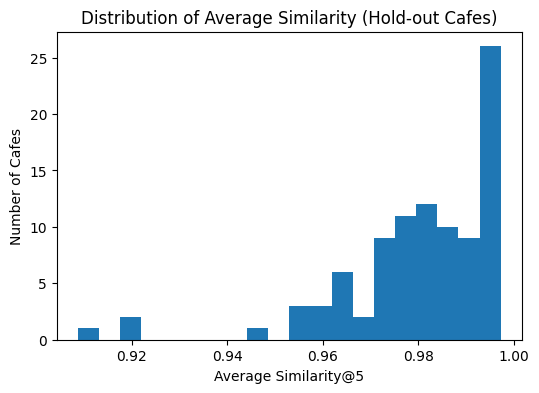

In [ ]:
# ====================================================
# Distribusi Avg Similarity per Item (HOLD-OUT)
# ====================================================

def eval_holdout_avg_sim_distribution(holdout_emb, k=5):
    avg_sim_scores = []

    for local_i, global_i in enumerate(holdout_idx):
        # Query café (hold-out)
        q = holdout_emb[local_i:local_i+1]

        # Similarity ke semua café
        scores = cosine_similarity(q, cafe_emb_matrix)[0]

        # Exclude self
        scores[global_i] = -1

        # Top-K
        order = scores.argsort()[::-1][:k]
        avg_sim_scores.append(np.mean(scores[order]))

    return avg_sim_scores


avg_sim_holdout_dist = eval_holdout_avg_sim_distribution(holdout_emb, k=5)

plt.figure(figsize=(6, 4))
plt.hist(avg_sim_holdout_dist, bins=20)
plt.xlabel('Average Similarity@5')
plt.ylabel('Number of Cafes')
plt.title('Distribution of Average Similarity (Hold-out Cafes)')
plt.show()
